In [23]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/nilsw/Lab1ID2223
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [24]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [25]:
def get_env(street,city):
    # Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
    if settings.HOPSWORKS_API_KEY is not None:
        api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
        os.environ['HOPSWORKS_API_KEY'] = api_key
    project = hopsworks.login()
    fs = project.get_feature_store() 
    
    secrets = hopsworks.get_secrets_api()
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{city.lower()}_{street.lower()}").value
    location = json.loads(location_str)
    print(location)
    country=location['country']
    city=location['city']
    street=location['street']

    return project, fs, country, city, street

In [26]:
def get_fgs(street,fs,city):
    # Retrieve feature groups
    air_quality_fg = fs.get_feature_group(
        name=f"air_quality_v_agrade_{city.lower()}_{street.lower()}",
        version=1,
    )
    weather_fg = fs.get_feature_group(
        name=f"weather_v_agrade_{city.lower()}_{street.lower()}",
        version=1,
    )
    return air_quality_fg, weather_fg

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [27]:
def set_selected_features(air_quality_fg, weather_fg):
    # Select features for training data.
    selected_features = air_quality_fg.select(['pm25', 'date',"rolling3","lag1d","lag2d","lag3d"]).join(weather_fg.select_features(), on=['city'])
    return selected_features

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [28]:
def create_fv(fs,selected_features,street,city):
    feature_view = fs.get_or_create_feature_view(
        name=f"air_quality_fv_v_agrade_{city.lower()}_{street.lower()}",
        description="weather features with air quality as the target",
        version=1,
        labels=['pm25'],
        query=selected_features,
    )
    return feature_view

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [29]:
#start_date_test_data = "2025-05-01"
# Convert string to datetime object
#test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [30]:
def create_train_data(feature_view):
    start_date_test_data = "2025-05-01"
    # Convert string to datetime object
    test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")
    X_train, X_test, y_train, y_test = feature_view.train_test_split(
        test_start=test_start
    )
    return X_train, X_test, y_train, y_test

In [31]:
#X_train

In [32]:
def get_features(X_train,X_test):
    X_features = X_train.drop(columns=['date'])
    X_test_features = X_test.drop(columns=['date'])
    return X_features, X_test_features

In [33]:
#y_train

The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [34]:
def create_and_train_model(X_features,y_train):
    # Creating an instance of the XGBoost Regressor
    xgb_regressor = XGBRegressor()
    
    # Fitting the XGBoost Regressor to the training data
    xgb_regressor.fit(X_features, y_train)
    return xgb_regressor

In [35]:
def predict_and_eval(xgb_regressor, X_test_features, y_test):
    # Predicting target values on the test set
    y_pred = xgb_regressor.predict(X_test_features)
    
    # Calculating Mean Squared Error (MSE) using sklearn
    mse = mean_squared_error(y_test.iloc[:,0], y_pred)
    print("MSE:", mse)
    
    # Calculating R squared using sklearn
    r2 = r2_score(y_test.iloc[:,0], y_pred)
    print("R squared:", r2)

    return y_pred, mse, r2

In [36]:
def create_test_df(y_test,y_pred,X_test):
    df = y_test
    df['predicted_pm25'] = y_pred
    
    df['date'] = X_test['date']
    df = df.sort_values(by=['date'])
    df.head(5)
    
    return df

In [37]:
#df['date'] = X_test['date']
#df = df.sort_values(by=['date'])
#df.head(5)

In [38]:
def create_dirs(street,city):
    # Creating a directory for the model artifacts if it doesn't exist
    model_dir = f"air_quality_model_{city.lower()}_{street}"
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    images_dir = model_dir + "/images"
    if not os.path.exists(images_dir):
        os.mkdir(images_dir)
    return model_dir, images_dir

In [39]:
def aq_plot(city,street,df,images_dir):
    file_path = images_dir + f"/pm25_hindcast_{city.lower()}_{street.lower()}.png"
    plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
    plt.show()

In [40]:
def importance_plot(xgb_regressor, street,images_dir,city):
    # Plotting feature importances using the plot_importance function from XGBoost
    plot_importance(xgb_regressor)
    feature_importance_path = images_dir + f"/feature_importance_{city.lower()}_{street.lower()}.png"
    plt.savefig(feature_importance_path)
    plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [41]:
def save_model(xgb_regressor, street,model_dir,city):
    # Saving the XGBoost regressor object as a json file in the model directory
    xgb_regressor.save_model(model_dir + f"/model_{city.lower()}_{street.lower()}.json")

In [42]:
#res_dict = { 
#        "MSE": str(mse),
#        "R squared": str(r2),
#    }

In [43]:
def save_model_hops(project, feature_view, street, model_dir, mse, r2,city):
    res_dict = { 
            "MSE": str(mse),
            "R squared": str(r2),
        }
    
    mr = project.get_model_registry()
    
    # Creating a Python model in the model registry named 'air_quality_xgboost_model'
    
    aq_model = mr.python.create_model(
        name=f"air_quality_xgboost_model_v_agrade_{city.lower()}_{street.lower()}", 
        metrics= res_dict,
        feature_view=feature_view,
        description="Air Quality (PM2.5) predictor",
    )
    
    # Saving the model artifacts to the 'air_quality_model' directory in the model registry
    aq_model.save(model_dir)

2025-11-16 15:12:42,263 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:12:42,277 INFO: Initializing external client
2025-11-16 15:12:42,278 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:12:43,853 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Miyoshi', 'street': 'Ikedacho_Machi', 'aqicn_url': 'https://api.waqi.info/feed/@4897', 'latitude': '34.0281684', 'longitude': '133.7985313'}
2025-11-16 15:12:46,077 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_miyoshi_ikedacho_machi` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.29s) 
MSE: 129.69194
R squared: 0.6001061504660468


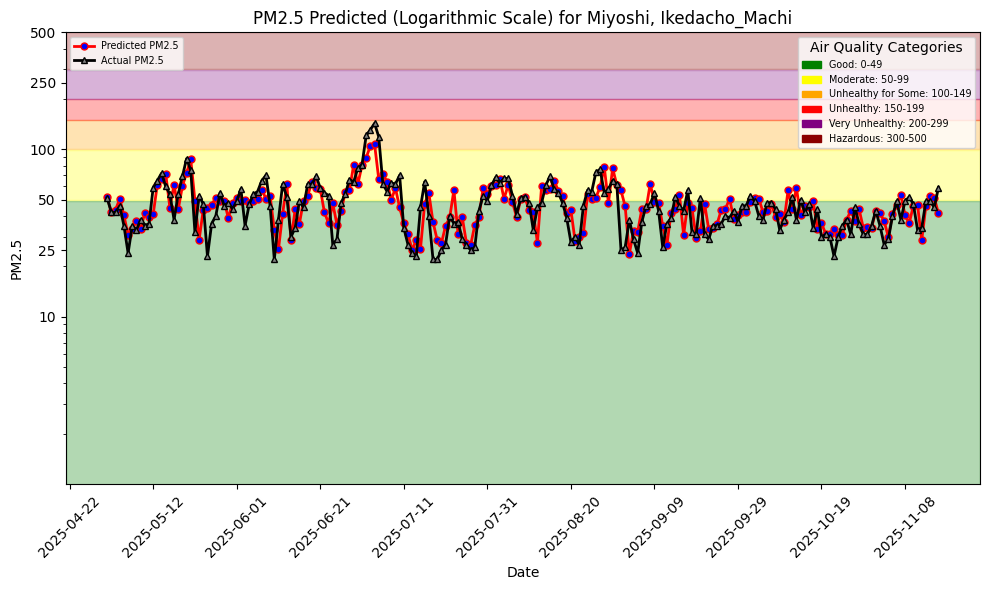

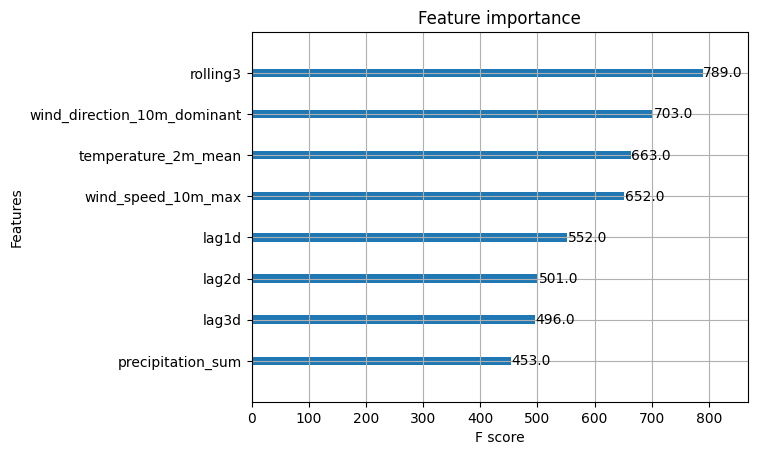

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_miyoshi_Ikedacho_Machi/model_miyoshi_i…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_miyoshi_Ikedacho_Machi/images/pm25_hin…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_miyoshi_Ikedacho_Machi/images/feature_…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_miyoshi_ikedacho_machi/1
2025-11-16 15:13:16,852 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:13:16,863 INFO: Initializing external client
2025-11-16 15:13:16,864 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:13:18,598 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Mima', 'street': 'Wakimachi_Oaza_Inoshiri', 'aqicn_url': 'https://api.waqi.info/feed/@4896', 'latitude': '34.0655131', 'longitude': '134.162842'}
2025-11-16 15:13:21,125 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_mima_wakimachi_oaza_inoshiri` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_mima_wakimachi_oaza_inoshiri/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.67s) 
MSE: 201.00613
R squared: 0.444034643876162


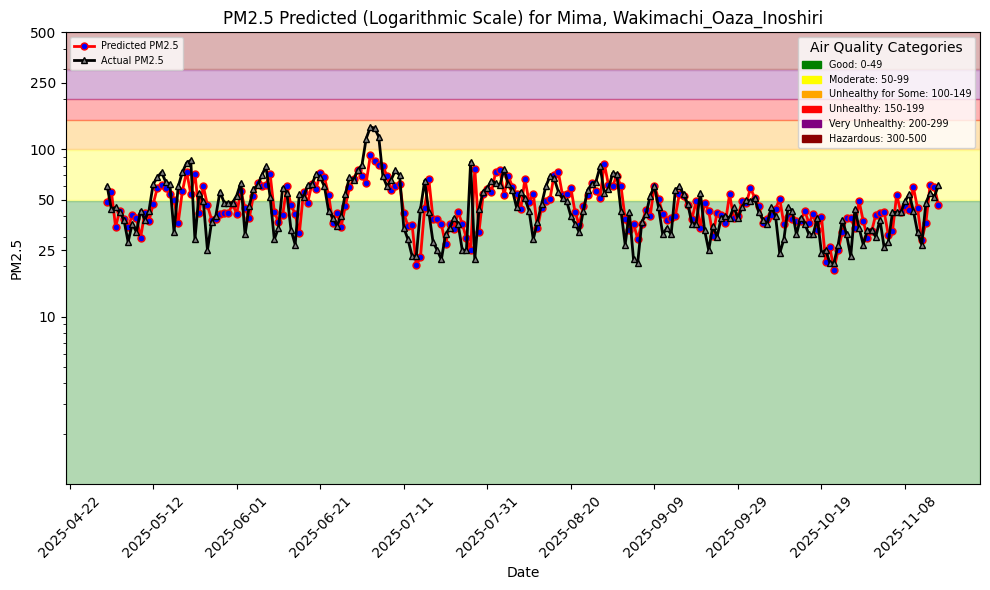

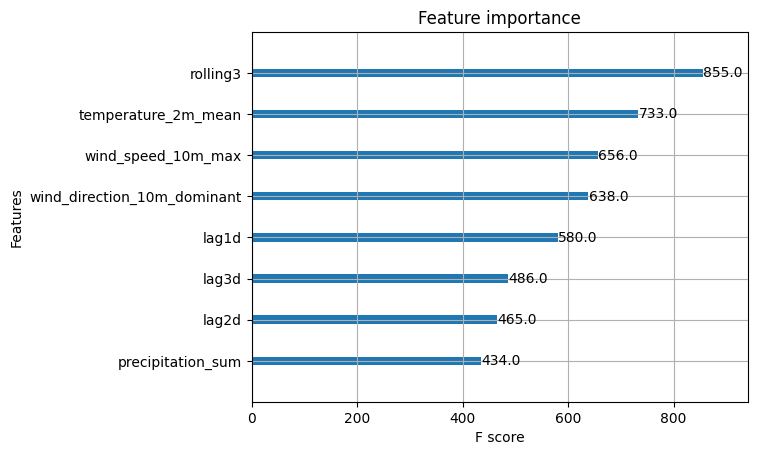

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_mima_Wakimachi_Oaza_Inoshiri/model_mim…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_mima_Wakimachi_Oaza_Inoshiri/images/pm…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_mima_Wakimachi_Oaza_Inoshiri/images/fe…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_mima_wakimachi_oaza_inoshiri/1
2025-11-16 15:13:53,160 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:13:53,167 INFO: Initializing external client
2025-11-16 15:13:53,168 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:13:54,654 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Naruto', 'street': 'Muyacho_Tateiwa', 'aqicn_url': 'https://api.waqi.info/feed/@4877', 'latitude': '34.1726236', 'longitude': '134.6139128'}
2025-11-16 15:13:56,923 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_naruto_muyacho_tateiwa` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_naruto_muyacho_tateiwa/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.47s) 
MSE: 148.0091
R squared: 0.5058090032972637


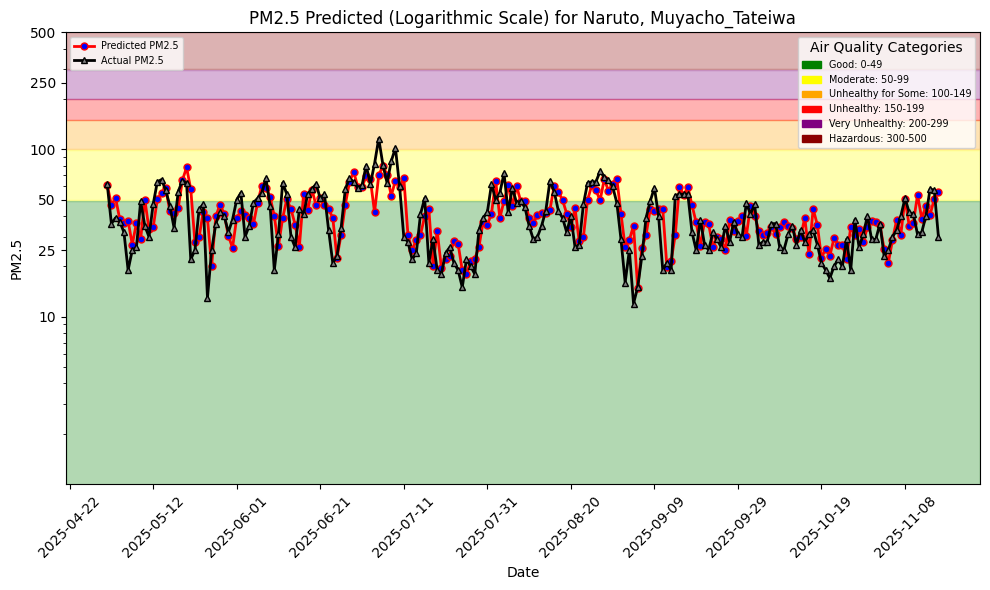

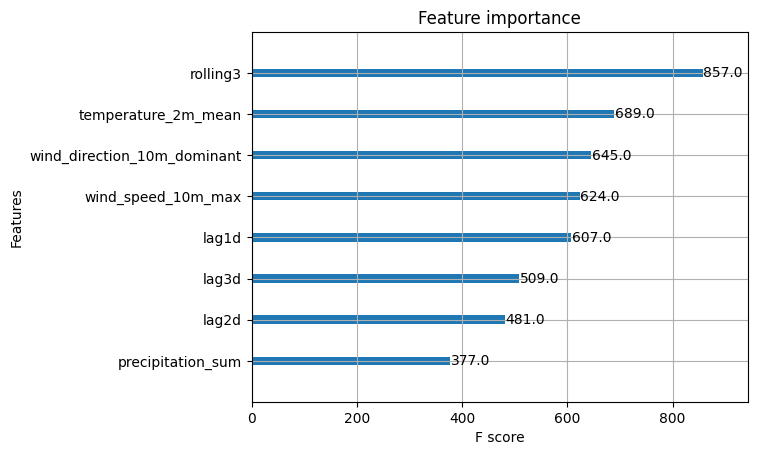

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_naruto_Muyacho_Tateiwa/model_naruto_mu…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_naruto_Muyacho_Tateiwa/images/pm25_hin…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_naruto_Muyacho_Tateiwa/images/feature_…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_naruto_muyacho_tateiwa/1
2025-11-16 15:14:28,864 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:14:28,869 INFO: Initializing external client
2025-11-16 15:14:28,870 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:14:30,350 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Kitajima', 'street': 'Tainohama', 'aqicn_url': 'https://api.waqi.info/feed/@4881', 'latitude': '34.1183893', 'longitude': '134.5430351'}
2025-11-16 15:14:32,853 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_kitajima_tainohama` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_kitajima_tainohama/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.41s) 
MSE: 176.95341
R squared: 0.49675888656399714


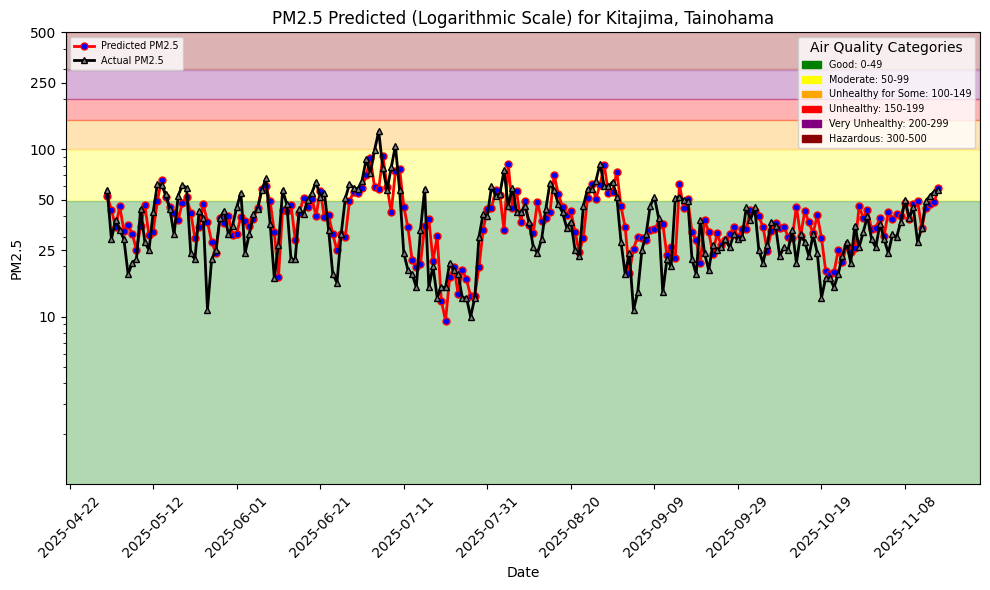

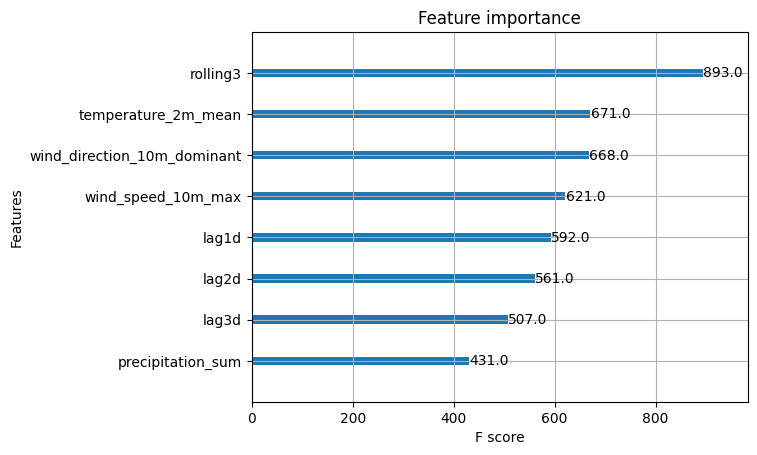

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_kitajima_Tainohama/model_kitajima_tain…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_kitajima_Tainohama/images/pm25_hindcas…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_kitajima_Tainohama/images/feature_impo…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_kitajima_tainohama/1
2025-11-16 15:15:07,677 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:15:07,682 INFO: Initializing external client
2025-11-16 15:15:07,683 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:15:09,280 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Tokushima', 'street': 'Shinkuracho', 'aqicn_url': 'https://api.waqi.info/feed/@4876', 'latitude': '34.0699925', 'longitude': '134.5606794'}
2025-11-16 15:15:11,704 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_tokushima_shinkuracho` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_tokushima_shinkuracho/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.31s) 
MSE: 153.55034
R squared: 0.5195630403696716


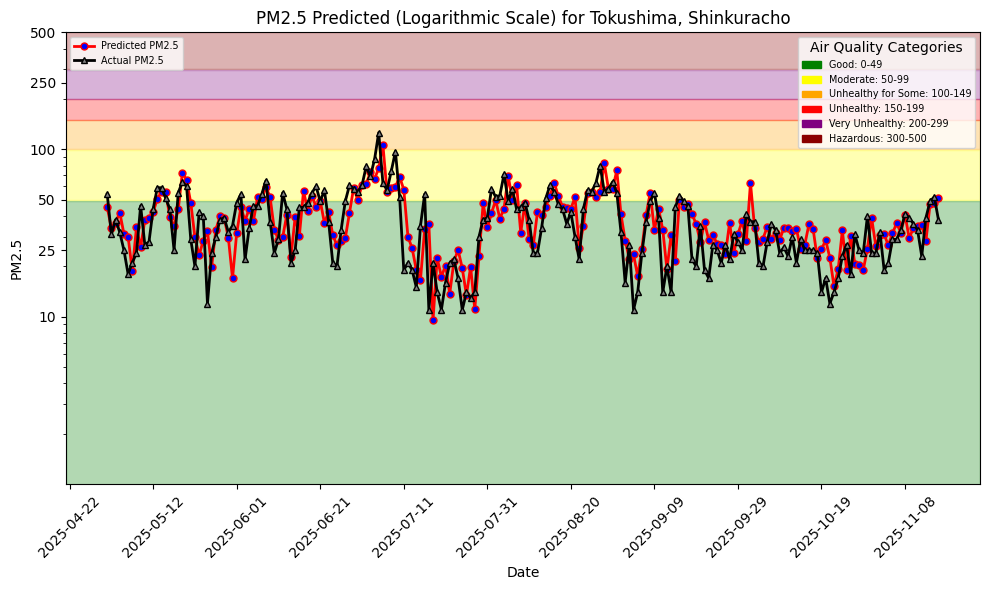

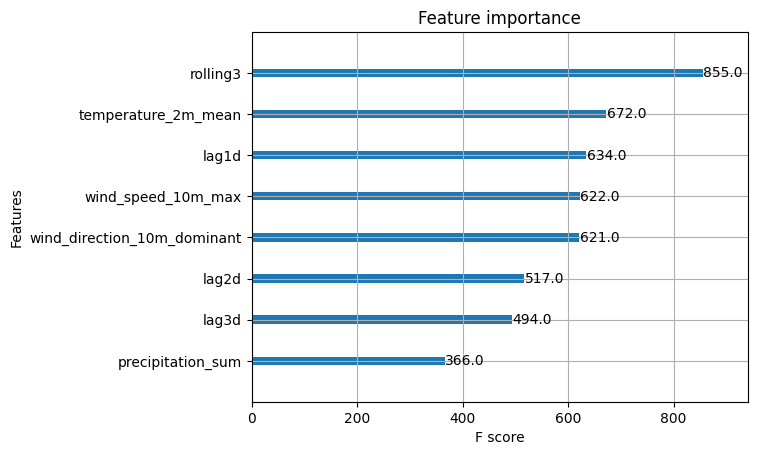

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_tokushima_Shinkuracho/model_tokushima_…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_tokushima_Shinkuracho/images/feature_i…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_tokushima_Shinkuracho/images/pm25_hind…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_tokushima_shinkuracho/1
2025-11-16 15:15:43,837 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:15:43,843 INFO: Initializing external client
2025-11-16 15:15:43,844 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:15:45,276 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Jinryo', 'street': 'Main_Street', 'aqicn_url': 'https://api.waqi.info/feed/@4879', 'latitude': '33.973282', 'longitude': '134.3683335'}
2025-11-16 15:15:47,559 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_jinryo_main_street` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_jinryo_main_street/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.28s) 
MSE: 166.29672
R squared: 0.5475006323163397


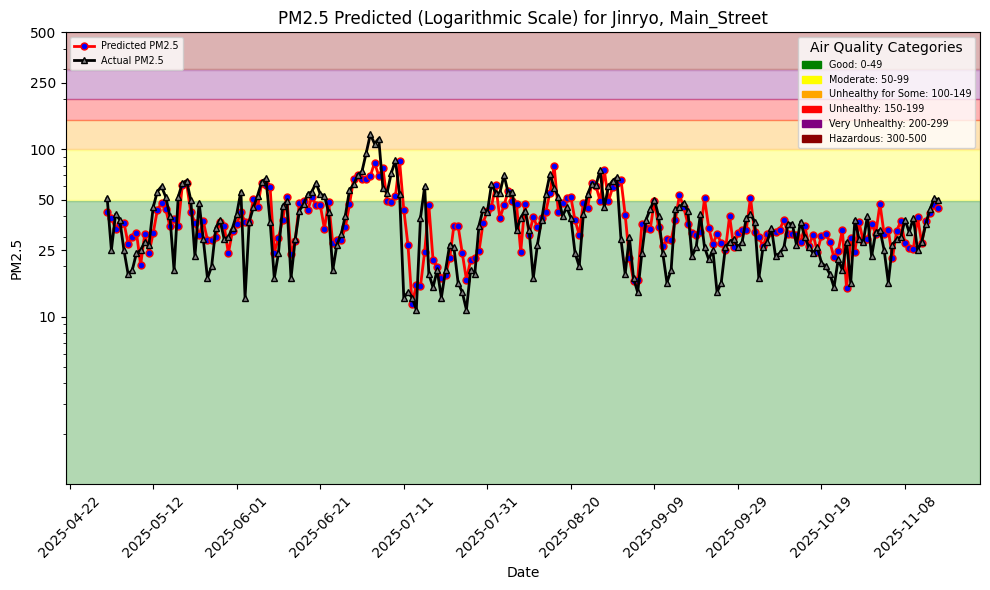

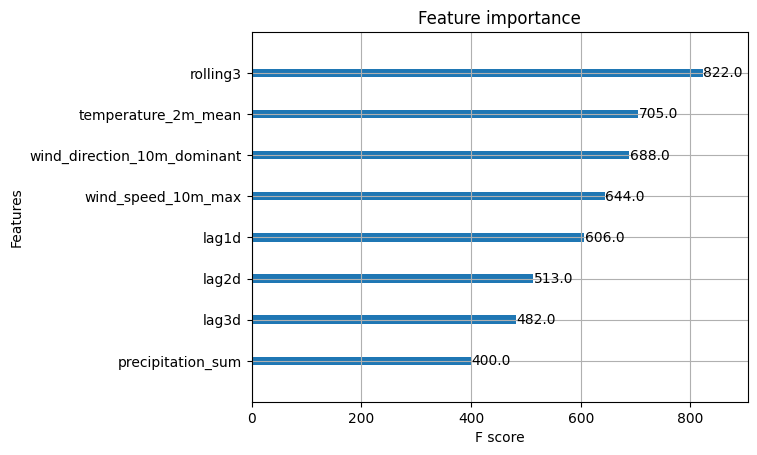

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_jinryo_Main_Street/model_jinryo_main_s…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_jinryo_Main_Street/images/pm25_hindcas…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_jinryo_Main_Street/images/feature_impo…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_jinryo_main_street/1
2025-11-16 15:16:18,410 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:16:18,436 INFO: Initializing external client
2025-11-16 15:16:18,437 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:16:20,145 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Anan', 'street': 'Nakagawacho_Kuroji', 'aqicn_url': 'https://api.waqi.info/feed/@4895', 'latitude': '33.9636504', 'longitude': '134.6414558'}
2025-11-16 15:16:22,441 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_anan_nakagawacho_kuroji` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_anan_nakagawacho_kuroji/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.20s) 
MSE: 199.67688
R squared: 0.5625073099378091


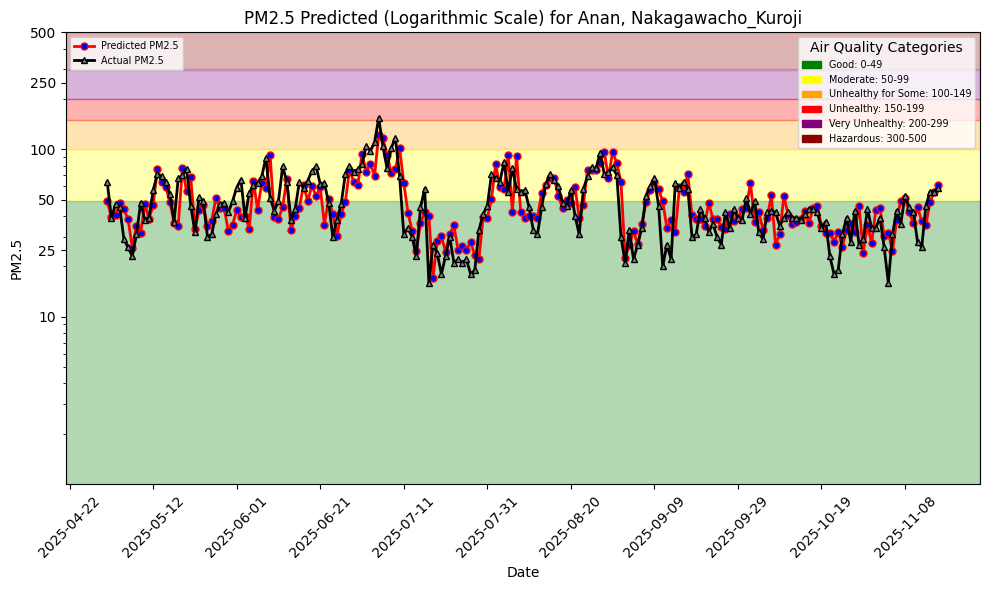

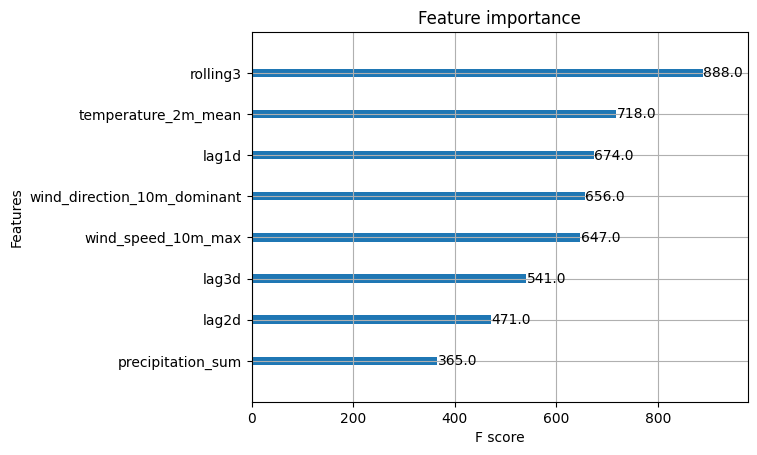

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_anan_Nakagawacho_Kuroji/model_anan_nak…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_anan_Nakagawacho_Kuroji/images/pm25_hi…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_anan_Nakagawacho_Kuroji/images/feature…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_anan_nakagawacho_kuroji/1
2025-11-16 15:16:52,261 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 15:16:52,269 INFO: Initializing external client
2025-11-16 15:16:52,270 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-16 15:16:53,683 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286328
{'country': 'Japan', 'city': 'Nishinoji', 'street': 'Main_Street', 'aqicn_url': 'https://api.waqi.info/feed/@4898', 'latitude': '33.7773037', 'longitude': '134.5984426'}
2025-11-16 15:16:56,011 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather_v_agrade_nishinoji_main_street` as features for the query. To include primary key and event time use `select_all`.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286328/fs/1273950/fv/air_quality_fv_v_agrade_nishinoji_main_street/version/1
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.84s) 
MSE: 185.59921
R squared: 0.46876178635444543


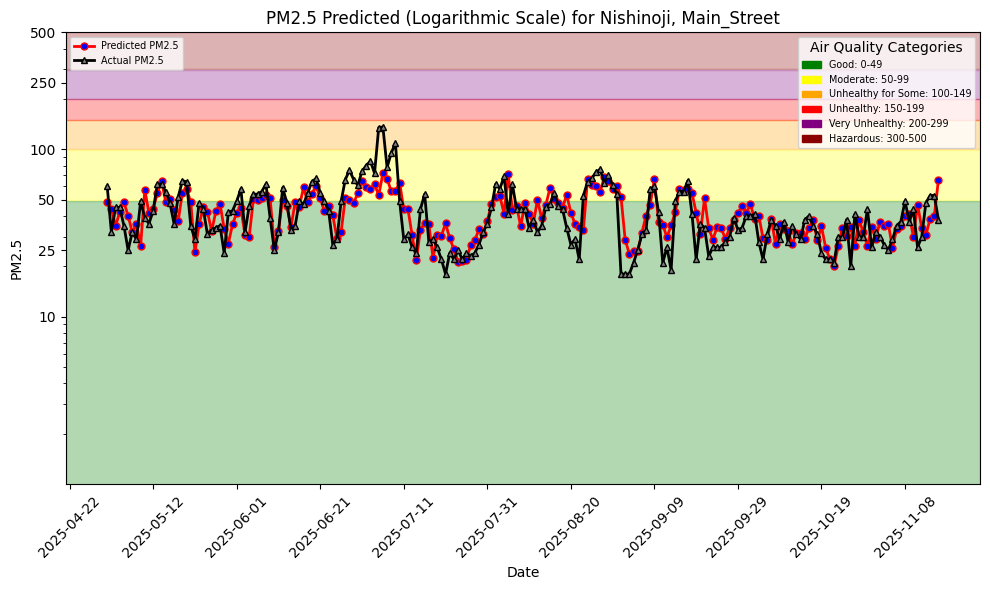

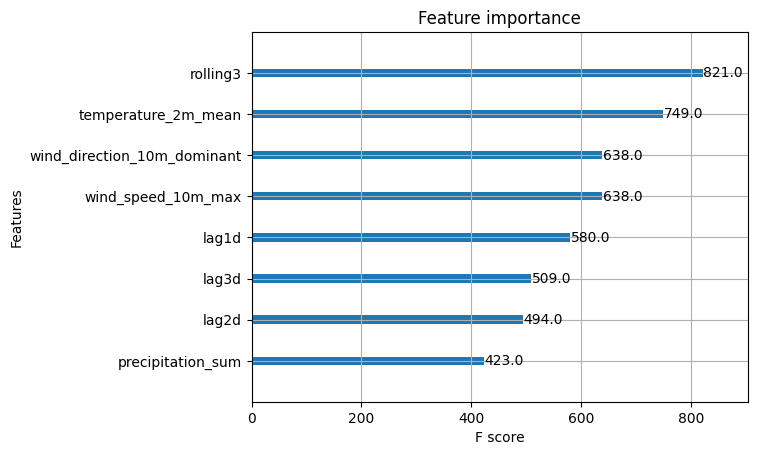

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_nishinoji_Main_Street/model_nishinoji_…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_nishinoji_Main_Street/images/feature_i…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/air_quality_model_nishinoji_Main_Street/images/pm25_hind…

Uploading /home/nilsw/Lab1ID2223/notebooks/airquality/model_schema.json: 0.000%|          | 0/839 elapsed<00:0…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286328/models/air_quality_xgboost_model_v_agrade_nishinoji_main_street/1


In [44]:
#locations = {"imahashi":"https://api.waqi.info/feed/@2543", "azuma":"https://api.waqi.info/feed/@2374", 
#             "oiwa":"https://api.waqi.info/feed/@2373", "noyori":"https://api.waqi.info/feed/@6600", "osaki":"https://api.waqi.info/feed/@2372"}

locations = {"https://api.waqi.info/feed/@4897":["Miyoshi", "Ikedacho_Machi"], "https://api.waqi.info/feed/@4896":["Mima","Wakimachi_Oaza_Inoshiri"], 
             "https://api.waqi.info/feed/@4877":["Naruto","Muyacho_Tateiwa"], "https://api.waqi.info/feed/@4881":["Kitajima","Tainohama"], 
             "https://api.waqi.info/feed/@4876":["Tokushima","Shinkuracho"], "https://api.waqi.info/feed/@4879":["Jinryo","Main_Street"], 
             "https://api.waqi.info/feed/@4895":["Anan","Nakagawacho_Kuroji"], "https://api.waqi.info/feed/@4898":["Nishinoji","Main_Street"]}


def full_pipeline(stations):

    for location in stations:
    
    
        url= location
        city= stations[location][0]
        country= "Japan"
        street= stations[location][1]
        
    
        project, fs, country, city, street = get_env(street,city)
    
        air_quality_fg, weather_fg = get_fgs(street, fs,city)
    
        selected_features = set_selected_features(air_quality_fg, weather_fg)
    
        feature_view = create_fv(fs,selected_features,street,city)
    
        X_train, X_test, y_train, y_test = create_train_data(feature_view)
    
        X_features, X_test_features = get_features(X_train,X_test)
    
        xgb_regressor = create_and_train_model(X_features,y_train)
    
        y_pred, mse, r2 = predict_and_eval(xgb_regressor, X_test_features, y_test)
    
        df = create_test_df(y_test,y_pred,X_test)
    
        model_dir, images_dir = create_dirs(street,city)
    
        aq_plot(city,street,df,images_dir)
    
        importance_plot(xgb_regressor, street,images_dir,city)
    
        save_model(xgb_regressor, street,model_dir,city)
    
        save_model_hops(project, feature_view, street, model_dir, mse, r2,city)

full_pipeline(locations)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
